In [1]:
import os

import pandas as pd
import numpy as np

from dotenv import load_dotenv
from nixtlats import TimeGPT
from IPython.display import Markdown

currDir = os.getcwd()
os.chdir("../data")
from dataUtils import generateQuery, movePlusRename, dataPrep  # noqa: E402

os.chdir("../usage")
from usageUtils import getUsage  # noqa: E402

os.chdir(currDir)

load_dotenv()

True

In [2]:
# Create a Kusto query to get sample data set from Azure Data Explorer

tenantId = "MS-DSZ04PrdStr04A"
daysAgo = 180

generateQuery(tenantId=tenantId, daysAgo=daysAgo)

XStoreAccountBillingDaily
    | where Tenant == "MS-DSZ04PrdStr04A"
        and TimePeriod >= ago(180d)
        and TimePeriod < now()
        and Environment != "Test"
        and isnotempty(MeterId)
    | where StgMeterName != "StgBlockBlobArchivePriorityRetrievalOperationUnitsBilled"
    | summarize ProratedQuantity = sum(ProratedQuantity) by bin(TimePeriod,1d), Tenant
    | project TimePeriod, Tenant, ProratedQuantity


NOTE: Manually pasting the query (copied to clipboard using pyperclip) into ADE, running, and exporting result to csv.

In [3]:
# Input params for sample billing data. The movePlusRename() function moves and renames the ADE query export file to this project directory and returns the new file name to be used in the dataPrep() function.

df = "df"
filename = movePlusRename(name="billing3_180")
timeCol = "TimePeriod"
dropCols = ["Tenant"]

bd180 = dataPrep(df, filename, timeCol, dropCols)

display(bd180.head())

succesfully moved and renamed export.csv in Downloads to billing3.csv in project data/raw folder


,TimePeriod,ProratedQuantity
0,2023-09-30,3.088484e+06
1,2023-10-01,3.055899e+06
2,2023-10-02,3.222214e+06
3,2023-10-03,3.290672e+06
4,2023-10-04,3.276783e+06


In [4]:
timegpt = TimeGPT()

In [5]:
# Get current API token usage data

getUsage()

Current usage data:

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  89   ||   TOKENS:  302414   ||   SPENT:  481.84          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (Default 99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
0,2023-11-01,0,3.037506e+06,3309305.50,3.581105e+06
1,2023-11-02,0,3.029432e+06,3301231.75,3.573031e+06
2,2023-11-03,0,2.979839e+06,3251638.75,3.523438e+06
3,2023-11-04,0,2.781941e+06,3053740.75,3.325540e+06
4,2023-11-05,0,2.735265e+06,3007064.75,3.278864e+06
...,...,...,...,...,...
142,2024-03-22,0,2.971325e+06,3243124.25,3.514924e+06
143,2024-03-23,0,2.758241e+06,3030040.50,3.301840e+06
144,2024-03-24,0,2.730807e+06,3002606.50,3.274406e+06
145,2024-03-25,0,2.971340e+06,3243139.50,3.514939e+06


### Detected Anomalies (Default 99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99


### Results Comparison Plot (Default 99% Prediction Interval Level)

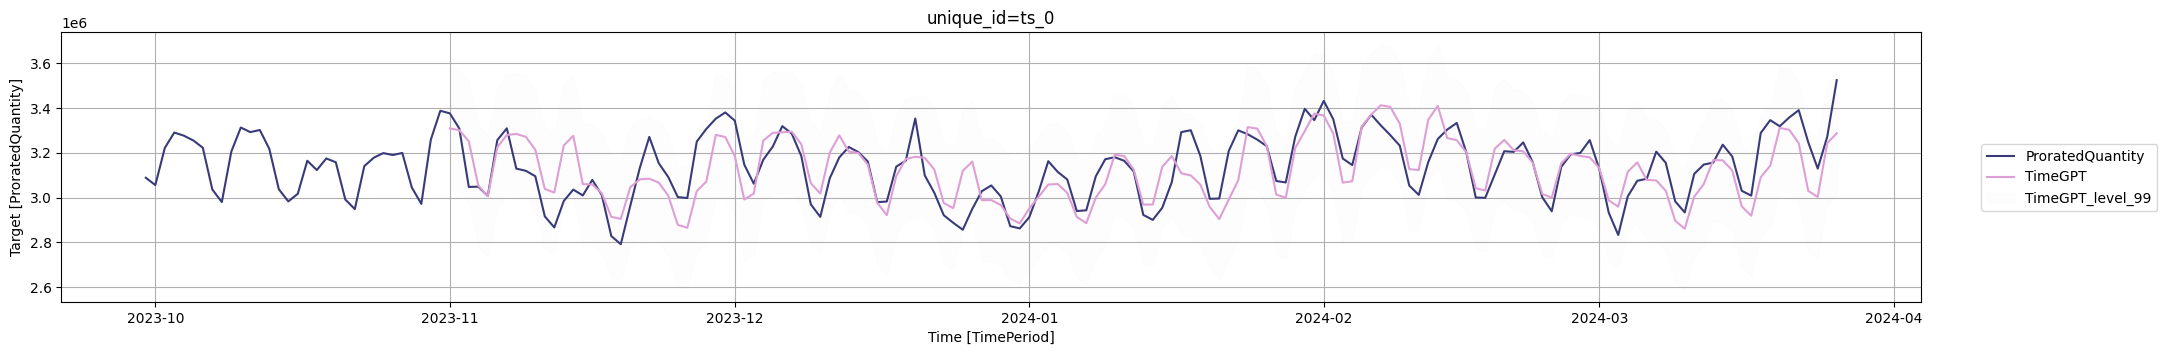

In [6]:
# Run anomaly detection model, plot results compared with original data (default prediction interval level is 99)

bd180Dtct = timegpt.detect_anomalies(
    bd180, time_col="TimePeriod", target_col="ProratedQuantity", freq="D"
)

bd180Anms = bd180Dtct[bd180Dtct["anomaly"] == 1]

bd180Plt = timegpt.plot(
    bd180, bd180Dtct, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (Default 99% Prediction Interval Level)"),
    bd180Dtct,
    Markdown("### Detected Anomalies (Default 99% Prediction Interval Level)"),
    bd180Anms,
    Markdown("### Results Comparison Plot (Default 99% Prediction Interval Level)"),
    bd180Plt,
)

In [7]:
# Get historical prediction intervals to test against detected anomalies

bd180Fcst = timegpt.forecast(
    bd180, h=1, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", add_history=True, level=[99, 90, 99.99],
)

bd180Fcst = bd180Fcst.merge(bd180)

for lv in [99, 90, 99.99]:
    bd180Fcst[f"anomaly_{lv}"] = (
        bd180Fcst["ProratedQuantity"] > bd180Fcst[f"TimeGPT-hi-{lv}"]
    ) | (
        bd180Fcst["ProratedQuantity"] < bd180Fcst[f"TimeGPT-lo-{lv}"]
    )

    bd180Fcst[f"anomaly_{lv}"] = bd180Fcst[f"anomaly_{lv}"].astype(np.int64)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Calling Historical Forecast Endpoint...


In [8]:
# Test detected anomalies against historical prediction intervals defalut level 99

pd.testing.assert_series_equal(
    bd180Fcst["anomaly_99"],
    bd180Dtct.merge(bd180)["anomaly"],
    check_index=False,
    check_names=False,
)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (90% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-90,TimeGPT,TimeGPT-hi-90
0,2023-11-01,0,3.135742e+06,3309305.50,3.482869e+06
1,2023-11-02,0,3.127668e+06,3301231.75,3.474795e+06
2,2023-11-03,1,3.078075e+06,3251638.75,3.425202e+06
3,2023-11-04,0,2.880177e+06,3053740.75,3.227304e+06
4,2023-11-05,0,2.833501e+06,3007064.75,3.180628e+06
...,...,...,...,...,...
142,2024-03-22,0,3.069561e+06,3243124.25,3.416688e+06
143,2024-03-23,1,2.856477e+06,3030040.50,3.203604e+06
144,2024-03-24,0,2.829043e+06,3002606.50,3.176170e+06
145,2024-03-25,0,3.069576e+06,3243139.50,3.416703e+06


### Detected Anomalies (90% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-90,TimeGPT,TimeGPT-hi-90
2,2023-11-03,1,3.078075e+06,3251638.75,3.425202e+06
12,2023-11-13,1,3.059738e+06,3233302.00,3.406866e+06
13,2023-11-14,1,3.102421e+06,3275984.25,3.449548e+06
21,2023-11-22,1,2.910826e+06,3084389.25,3.257953e+06
26,2023-11-27,1,2.855541e+06,3029104.50,3.202668e+06
27,2023-11-28,1,2.897874e+06,3071437.75,3.245001e+06
54,2023-12-25,1,2.946012e+06,3119575.50,3.293139e+06
55,2023-12-26,1,2.987523e+06,3161086.50,3.334650e+06
75,2024-01-15,1,2.964032e+06,3137595.25,3.311159e+06
77,2024-01-17,1,2.935159e+06,3108723.00,3.282287e+06


### Results Comparison Plot (90% Prediction Interval Level)

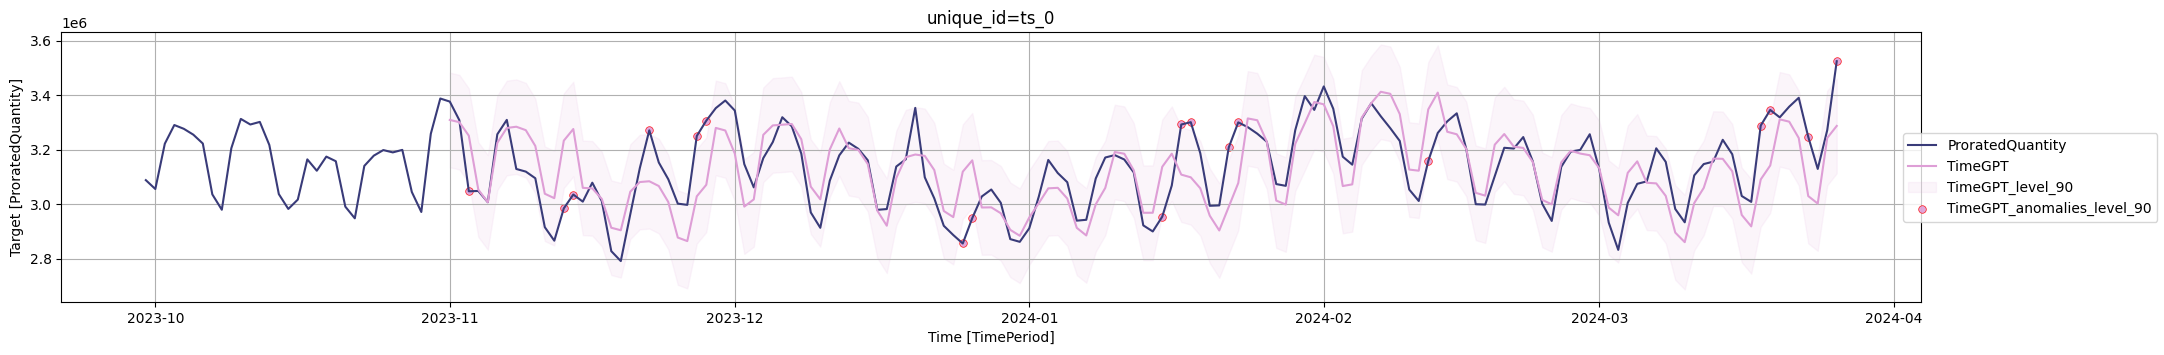

In [9]:
# Run anomaly detection model, plot results compared with original data (prediction interval level 90 should identify more anomalies)

bd180Dtct90 = timegpt.detect_anomalies(
    bd180, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", level=90
)

bd180Anms90 = bd180Dtct90[bd180Dtct90["anomaly"] == 1]

bd180Plt90 = timegpt.plot(
    bd180, bd180Dtct90, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (90% Prediction Interval Level)"),
    bd180Dtct90,
    Markdown("### Detected Anomalies (90% Prediction Interval Level)"),
    bd180Anms90,
    Markdown("### Results Comparison Plot (90% Prediction Interval Level)"),
    bd180Plt90,
)

In [10]:
# Test detected anomalies against historical prediction interval level 90

pd.testing.assert_series_equal(
    bd180Fcst["anomaly_90"],
    bd180Dtct90.merge(bd180)["anomaly"],
    check_index=False,
    check_names=False,
)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (99.99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99
0,2023-11-01,0,2.898774e+06,3309305.50,3.719837e+06
1,2023-11-02,0,2.890700e+06,3301231.75,3.711764e+06
2,2023-11-03,0,2.841107e+06,3251638.75,3.662171e+06
3,2023-11-04,0,2.643209e+06,3053740.75,3.464273e+06
4,2023-11-05,0,2.596533e+06,3007064.75,3.417597e+06
...,...,...,...,...,...
142,2024-03-22,0,2.832592e+06,3243124.25,3.653656e+06
143,2024-03-23,0,2.619509e+06,3030040.50,3.440572e+06
144,2024-03-24,0,2.592075e+06,3002606.50,3.413138e+06
145,2024-03-25,0,2.832608e+06,3243139.50,3.653671e+06


### Detected Anomalies (99.99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99


### Results Comparison Plot (99.99% Prediction Interval Level)

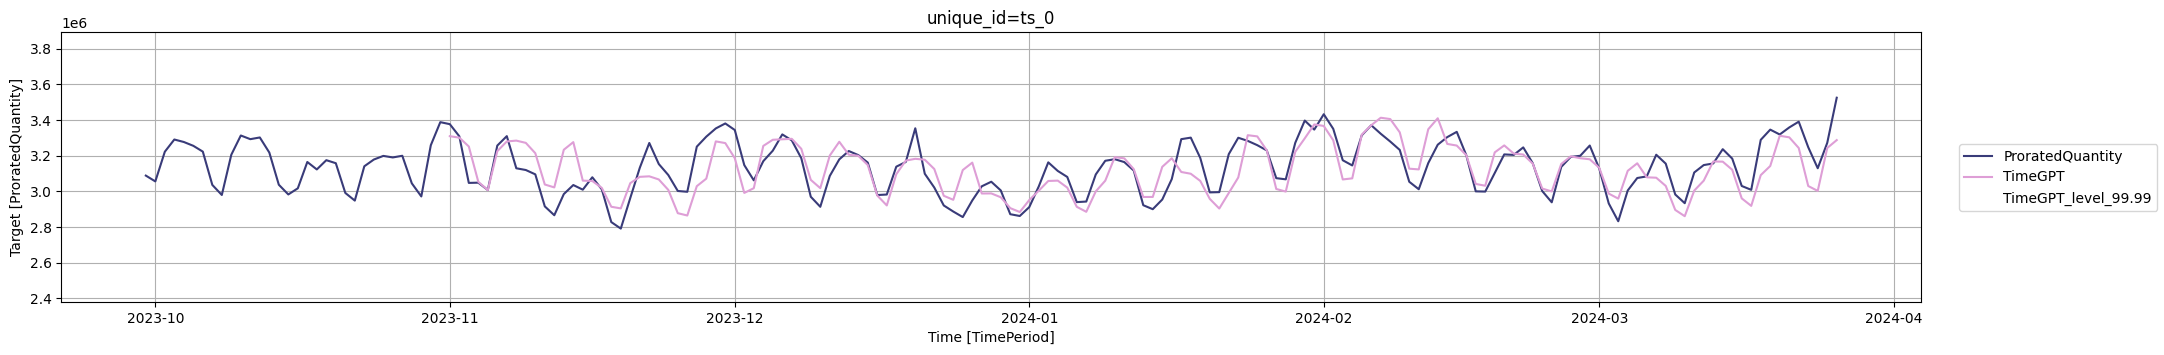

In [11]:
# Run anomaly detection model, plot results compared with original data (prediction interval level 99.99 should identify fewer anomalies)

bd180Dtct99_99 = timegpt.detect_anomalies(
    bd180, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", level=99.99,
)

bd180Anms99_99 = bd180Dtct99_99[bd180Dtct99_99["anomaly"] == 1]

bd180Plt99_99 = timegpt.plot(
    bd180, bd180Dtct99_99, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (99.99% Prediction Interval Level)"),
    bd180Dtct99_99,
    Markdown("### Detected Anomalies (99.99% Prediction Interval Level)"),
    bd180Anms99_99,
    Markdown("### Results Comparison Plot (99.99% Prediction Interval Level)"),
    bd180Plt99_99,
)

In [12]:
# Test detected anomalies against historical prediction interval level 99.99

pd.testing.assert_series_equal(
    bd180Fcst["anomaly_99.99"],
    bd180Dtct99_99.merge(bd180)["anomaly"],
    check_index=False,
    check_names=False,
)

In [13]:
# Get updated API token usage data

getUsage(update=True)

Usage data successfully updated with:               

<<  5 calls  •  4283 tokens  •  11.93 spent  >>

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 

          API CALLS:  94   ||   TOKENS:  306697   ||   SPENT:  493.77          

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


In [14]:
# Create a Kusto query to get sample data set from Azure Data Explorer

tenantId = "MS-DSZ04PrdStr04A"
daysAgo = 90

generateQuery(tenantId=tenantId, daysAgo=daysAgo)

XStoreAccountBillingDaily
    | where Tenant == "MS-DSZ04PrdStr04A"
        and TimePeriod >= ago(90d)
        and TimePeriod < now()
        and Environment != "Test"
        and isnotempty(MeterId)
    | where StgMeterName != "StgBlockBlobArchivePriorityRetrievalOperationUnitsBilled"
    | summarize ProratedQuantity = sum(ProratedQuantity) by bin(TimePeriod,1d), Tenant
    | project TimePeriod, Tenant, ProratedQuantity


NOTE: Manually pasting the query (copied to clipboard using pyperclip) into ADE, running, and exporting result to csv.

In [16]:
# Input params for sample billing data and run data prep function. The function movePlusRename moves and renames the ADE query export file to this project directory and returns the new file name.

df = "df"
filename = movePlusRename(name="billing3_90")
timeCol = "TimePeriod"
dropCols = ["Tenant"]

bd90 = dataPrep(df=df, filename=filename, timeCol=timeCol, dropCols=dropCols)

display(bd90.head())

succesfully moved and renamed export.csv in Downloads to billing3_90.csv in project data/raw folder


,TimePeriod,ProratedQuantity
0,2023-12-29,3.005289e+06
1,2023-12-30,2.872112e+06
2,2023-12-31,2.862126e+06
3,2024-01-01,2.911957e+06
4,2024-01-02,3.027888e+06


INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (Default 99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99
0,2024-01-31,0,3.129129e+06,3375147.00,3.621165e+06
1,2024-02-01,0,3.120606e+06,3366624.00,3.612642e+06
2,2024-02-02,0,3.040190e+06,3286207.50,3.532225e+06
3,2024-02-03,0,2.820822e+06,3066840.00,3.312858e+06
4,2024-02-04,0,2.826998e+06,3073016.00,3.319034e+06
5,2024-02-05,0,3.071788e+06,3317806.00,3.563824e+06
6,2024-02-06,0,3.124667e+06,3370684.50,3.616702e+06
7,2024-02-07,0,3.166651e+06,3412668.25,3.658686e+06
8,2024-02-08,0,3.159249e+06,3405266.75,3.651284e+06
9,2024-02-09,0,3.084851e+06,3330868.50,3.576886e+06


### Detected Anomalies (Default 99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99,TimeGPT,TimeGPT-hi-99


### Results Comparison Plot (Default 99% Prediction Interval Level)

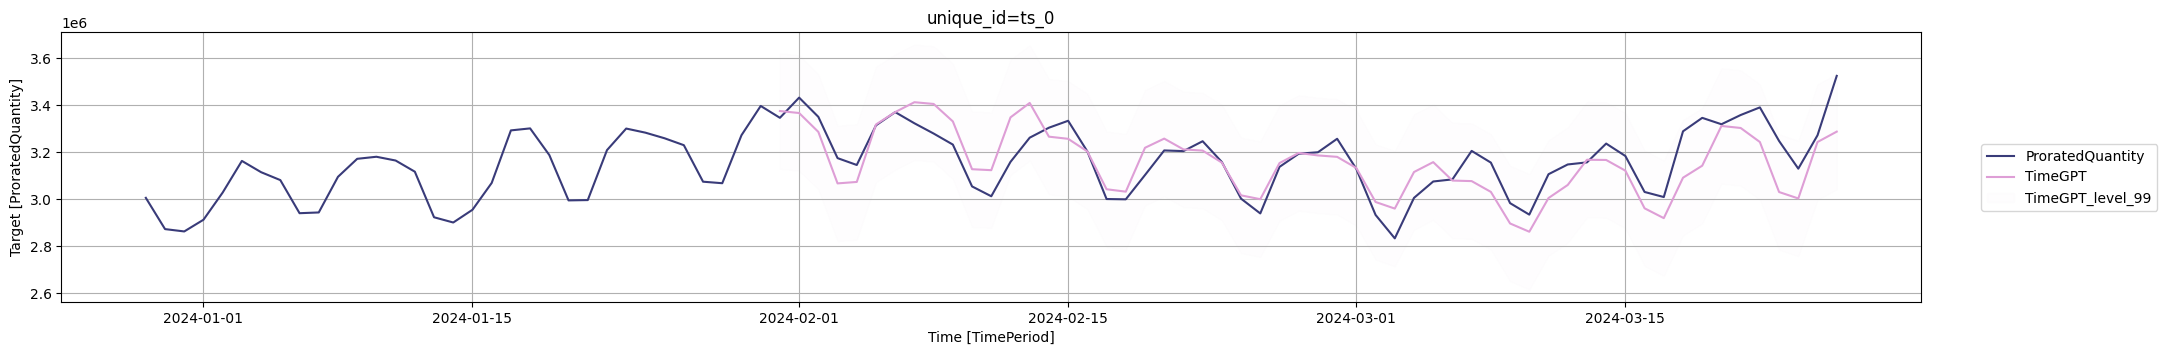

In [17]:
# Run anomaly detection model, plot results compared with original data (default prediction interval level is 99)

bd90Dtct = timegpt.detect_anomalies(
    bd90, time_col="TimePeriod", target_col="ProratedQuantity", freq="D"
)

bd90Anms = bd90Dtct[bd90Dtct["anomaly"] == 1]

bd90Plt = timegpt.plot(
    bd90, bd90Dtct, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (Default 99% Prediction Interval Level)"),
    bd90Dtct,
    Markdown("### Detected Anomalies (Default 99% Prediction Interval Level)"),
    bd90Anms,
    Markdown("### Results Comparison Plot (Default 99% Prediction Interval Level)"),
    bd90Plt,
)

In [18]:
# Get historical prediction intervals to test against detected anomalies

bd90Fcst = timegpt.forecast(
    bd90, h=1, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", add_history=True, level=[99, 90, 99.99],
)

bd90Fcst = bd90Fcst.merge(bd90)

for lv in [99, 90, 99.99]:
    bd90Fcst[f"anomaly_{lv}"] = (
        bd90Fcst["ProratedQuantity"] > bd90Fcst[f"TimeGPT-hi-{lv}"]
    ) | (
        bd90Fcst["ProratedQuantity"] < bd90Fcst[f"TimeGPT-lo-{lv}"]
    )

    bd90Fcst[f"anomaly_{lv}"] = bd90Fcst[f"anomaly_{lv}"].astype(np.int64)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Forecast Endpoint...
INFO:nixtlats.timegpt:Calling Historical Forecast Endpoint...


In [19]:
# Test detected anomalies against historical prediction intervals defalut level 99

pd.testing.assert_series_equal(
    bd90Fcst["anomaly_99"],
    bd90Dtct.merge(bd90)["anomaly"],
    check_index=False,
    check_names=False,
)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (90% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-90,TimeGPT,TimeGPT-hi-90
0,2024-01-31,0,3.218047e+06,3375147.00,3.532247e+06
1,2024-02-01,0,3.209524e+06,3366624.00,3.523724e+06
2,2024-02-02,0,3.129107e+06,3286207.50,3.443308e+06
3,2024-02-03,0,2.909740e+06,3066840.00,3.223940e+06
4,2024-02-04,0,2.915916e+06,3073016.00,3.230116e+06
5,2024-02-05,0,3.160706e+06,3317806.00,3.474906e+06
6,2024-02-06,0,3.213584e+06,3370684.50,3.527785e+06
7,2024-02-07,0,3.255568e+06,3412668.25,3.569768e+06
8,2024-02-08,0,3.248167e+06,3405266.75,3.562367e+06
9,2024-02-09,0,3.173768e+06,3330868.50,3.487969e+06


### Detected Anomalies (90% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-90,TimeGPT,TimeGPT-hi-90
12,2024-02-12,1,3.190985e+06,3348085.00,3.505185e+06
47,2024-03-18,1,2.933911e+06,3091011.50,3.248112e+06
48,2024-03-19,1,2.985168e+06,3142267.75,3.299368e+06
52,2024-03-23,1,2.872940e+06,3030040.50,3.187141e+06
55,2024-03-26,1,3.130265e+06,3287364.75,3.444465e+06


### Results Comparison Plot (90% Prediction Interval Level)

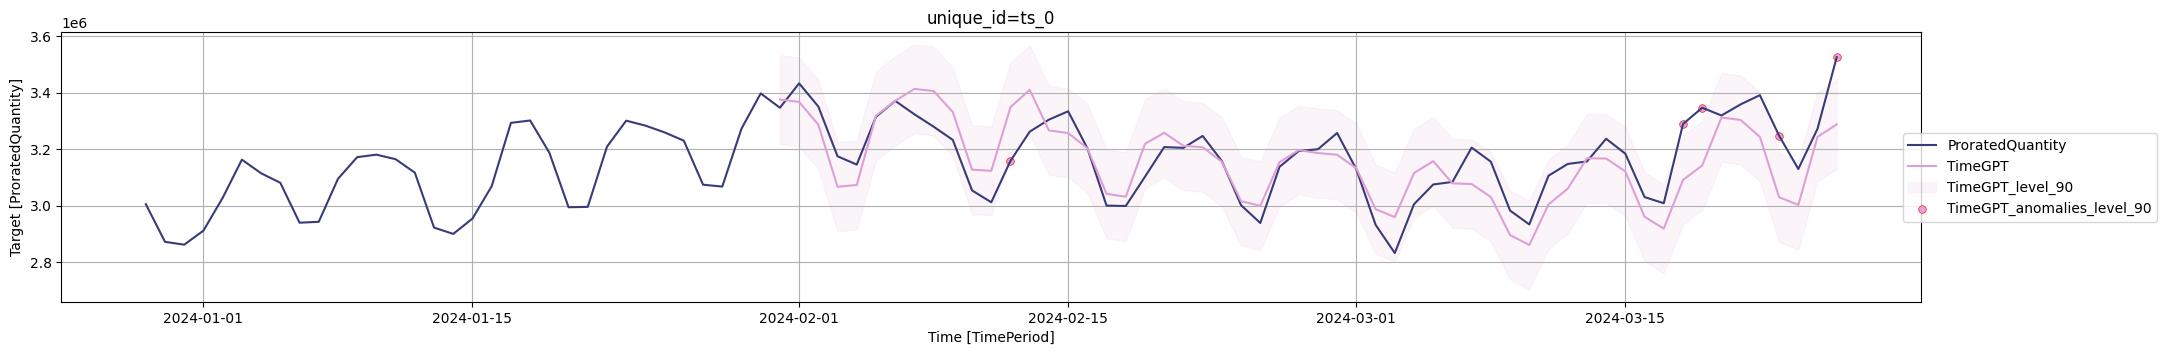

In [20]:
# Run anomaly detection model, plot results compared with original data (prediction interval level 90 should identify more anomalies)

bd90Dtct90 = timegpt.detect_anomalies(
    bd90, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", level=90
)

bd90Anms90 = bd90Dtct90[bd90Dtct90["anomaly"] == 1]

bd90Plt90 = timegpt.plot(
    bd90, bd90Dtct90, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (90% Prediction Interval Level)"),
    bd90Dtct90,
    Markdown("### Detected Anomalies (90% Prediction Interval Level)"),
    bd90Anms90,
    Markdown("### Results Comparison Plot (90% Prediction Interval Level)"),
    bd90Plt90,
)

In [21]:
# Test detected anomalies against historical prediction interval level 90

pd.testing.assert_series_equal(
    bd90Fcst["anomaly_90"],
    bd90Dtct90.merge(bd90)["anomaly"],
    check_index=False,
    check_names=False,
)

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


### Anomalies Detection Result (99.99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99
0,2024-01-31,0,3.003556e+06,3375147.00,3.746738e+06
1,2024-02-01,0,2.995033e+06,3366624.00,3.738215e+06
2,2024-02-02,0,2.914617e+06,3286207.50,3.657798e+06
3,2024-02-03,0,2.695249e+06,3066840.00,3.438431e+06
4,2024-02-04,0,2.701425e+06,3073016.00,3.444607e+06
5,2024-02-05,0,2.946215e+06,3317806.00,3.689397e+06
6,2024-02-06,0,2.999094e+06,3370684.50,3.742275e+06
7,2024-02-07,0,3.041078e+06,3412668.25,3.784259e+06
8,2024-02-08,0,3.033676e+06,3405266.75,3.776857e+06
9,2024-02-09,0,2.959278e+06,3330868.50,3.702459e+06


### Detected Anomalies (99.99% Prediction Interval Level)

,TimePeriod,anomaly,TimeGPT-lo-99.99,TimeGPT,TimeGPT-hi-99.99


### Results Comparison Plot (99.99% Prediction Interval Level)

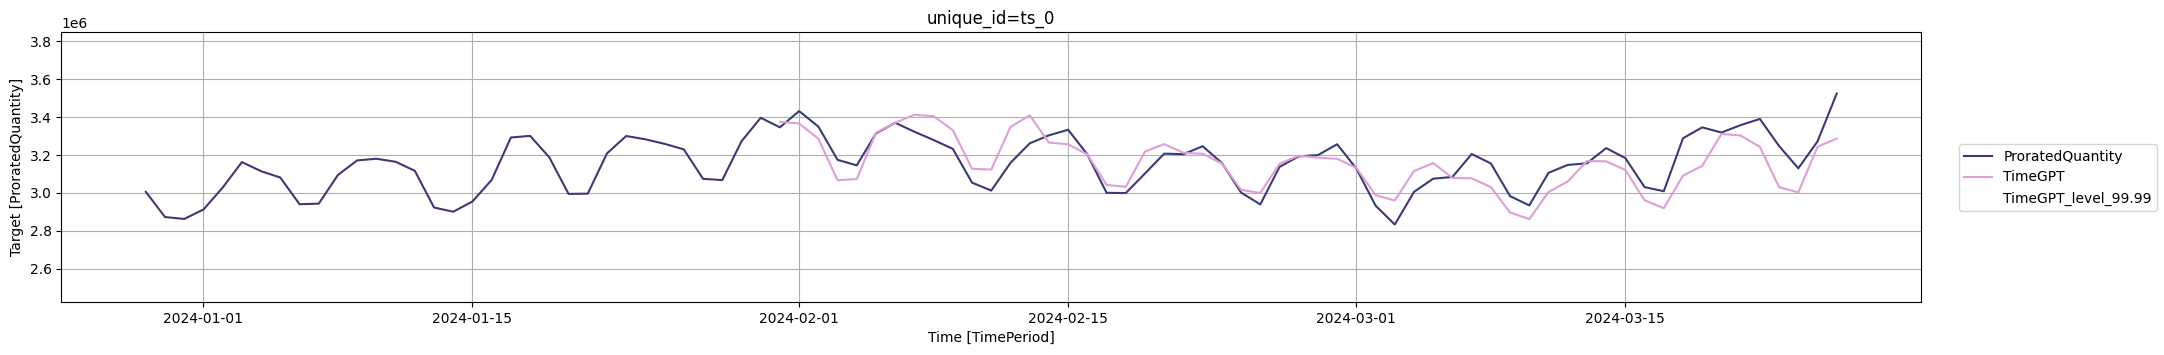

In [22]:
# Run anomaly detection model, plot results compared with original data (prediction interval level 99.99 should identify fewer anomalies)

bd90Dtct99_99 = timegpt.detect_anomalies(
    bd90, time_col="TimePeriod", target_col="ProratedQuantity", freq="D", level=99.99,
)

bd90Anms99_99 = bd90Dtct99_99[bd90Dtct99_99["anomaly"] == 1]

bd90Plt99_99 = timegpt.plot(
    bd90, bd90Dtct99_99, time_col="TimePeriod", target_col="ProratedQuantity"
)

display(
    Markdown("### Anomalies Detection Result (99.99% Prediction Interval Level)"),
    bd90Dtct99_99,
    Markdown("### Detected Anomalies (99.99% Prediction Interval Level)"),
    bd90Anms99_99,
    Markdown("### Results Comparison Plot (99.99% Prediction Interval Level)"),
    bd90Plt99_99,
)

In [23]:
# Test detected anomalies against historical prediction interval level 99.99

pd.testing.assert_series_equal(
    bd90Fcst["anomaly_99.99"],
    bd90Dtct99_99.merge(bd90)["anomaly"],
    check_index=False,
    check_names=False,
)